# Evolutionary solution with Backward-Time Centered-Space scheme (BTCS)

Evolutionary (time-dependent) solution of heat equation require initial conditions, which deviate from steady-state solution. In this exercise we

  1. Calculate steady-state solution
  2. Alter the solution to push it out of steady-state equilibrium
  3. We will solve evolutionary equation to track how system getting back towards the equilibrium

**Keep in mind, that steady-state solution is the one with zero time-derivate, so there is no change in time.**

In this example we will examine how to calculate evolutionary solution of thermal structure in layered crust. We will use simple three layer structure of the crust.
  * Upper crust 15km, $\lambda$=2.5 Wm-1K-1, $H$=1e-6 Wm-3, c=900, $\rho$=2700
  * Middle crust 10km, $\lambda$=2.3 Wm-1K-1, no heat production, c=800, $\rho$=2900
  * Lower crust 10km, $\lambda$=2.1 Wm-1K-1, no heat production, c=750, $\rho$=3000

As the conductivity, heat production, heat capacity and density is no more constant, we need to store then in arrays. Based on our staggered grid design, those arrays are 1 element smaller comparing to calculation grid.

In [1]:
%pylab inline

from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve

Populating the interactive namespace from numpy and matplotlib


### 1. Calculate steady-state solution

Here we will use stedy state solution from last exercise, we just increase number of nodes for better resolution.

In [2]:
T0 = 0                       # Surface temperature
th = 35000                   # thickness of the crust
n = 351                      # number of nodes
dx = th/(n-1)                # node spacing
x = linspace(0, th, n)    # calculation grid positions
q = -32e-3                   # mantle heat flow

Now we need to create material properties arrays. We will use Python list multiplification trick. Note that node spacing is 100m.

In [3]:
k = array(150*[2.5] + 100*[2.3] + 100*[2.1])       # conductivities 
H = array(150*[1e-6] + 200*[0])                    # heat productions
xm = linspace(dx/2, 35000-dx/2, n-1)               # material grid positions

In [4]:
kl, kr = k[:-1], k[1:]
Hl, Hr = H[:-1], H[1:]

In [5]:
# diagonals including boundary conditions
dl = hstack((kl, 2*k[-1], 0))
dr = hstack((0, 0, kr))
dm = hstack((1, -(kl + kr), -2*k[-1]))

# Sparse coefficient matrix
A = spdiags([dl, dm, dr], [-1, 0, 1], n, n, 'csr')

# Column vector of constant terms and BC
b = hstack((T0, -(Hl + Hr)*dx**2 / 2, 2*q*dx - H[-1]*dx**2))

Thats it. Now just solve and plot. Note use of ``spsolve``

In [6]:
T = spsolve(A, b)

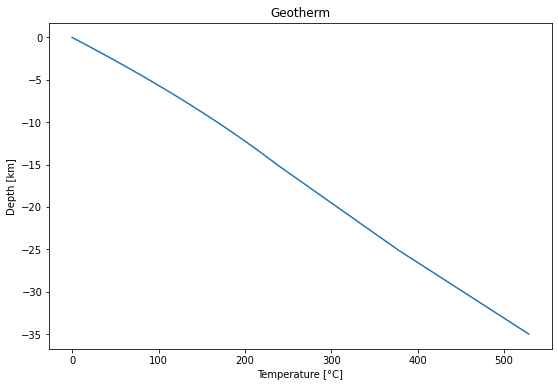

In [7]:
figure(figsize=(9, 6))
plot(T, -x/1000)
xlabel('Temperature [°C]')
ylabel('Depth [km]')
title('Geotherm')
show()

### 2. Alter the solution to push it out of steady-state equilibrium

In our first case we will imagine instantaneous intrusion of hot magmatic rock between 10-15 km depth with temperature 700°C

In [8]:
Ti = T.copy()
Ti[(x>=10000) & (x<=15000)] = 700

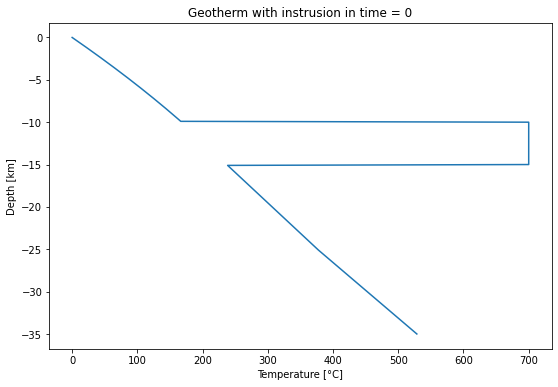

In [9]:
figure(figsize=(9, 6))
plot(Ti, -x/1000)
xlabel('Temperature [°C]')
ylabel('Depth [km]')
title('Geotherm with instrusion in time = 0')
show()

### 3. Evolutionary (time-dependent) solution

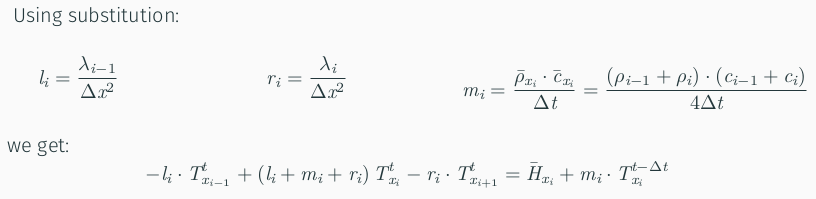

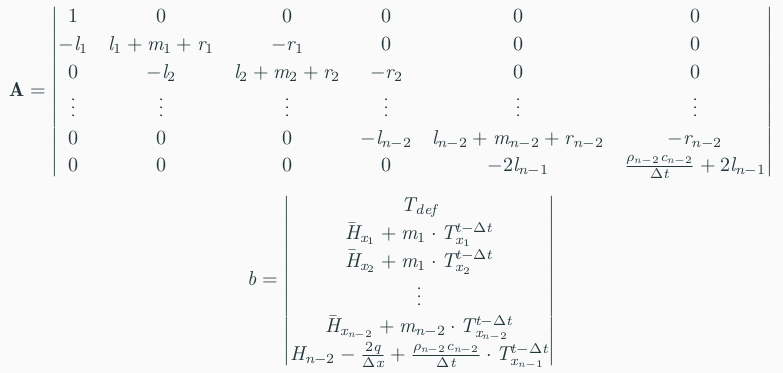

At first we set parameters of the model. Note that we need *density* and *specific heat* for time-dependent problems. We also introduce *ysec* variable to express time in seconds using years and *dt* for time step

In [10]:
rho = array(150 * [2700] + 100 * [2900] + 100 * [3000])  # density
c = array(150 * [900] + 100 * [800] + 100 * [750])       # heat capacity
ysec = 365.25*24*3600   # one year in seconds
dt = 100*ysec           # time step of hundred years

In [11]:
# helpers
l = k[:-1] / dx**2
r = k[1:] / dx**2
m = (rho[:-1] + rho[1:]) * (c[:-1] + c[1:]) / (4 * dt)

Now we assemble coefficient matrix A using Dirichlet boundary at surface and Neumann boundary condition at MOHO

In [12]:
# Sparse coefficient matrix A
dl = hstack((-l, -2*l[-1], 0))
dh = hstack((1, m + l + r, rho[-1] * c[-1] / dt + 2 * l[-1]))
du = hstack((0, 0, -r))
A = spdiags([dl, dh, du], [-1,0,1], n, n, 'csr')

The column vector of constant terms $b$ will be created in solution loop as it needs to be updated after each time step

Now we can calculate time evolution by solving system of equations $AT^t = b$. We will do 1000 calculations, each for 100 years  time-step, i.e. we will calculate temperature distribution after 100000 years.

In [13]:
Tn = Ti.copy()
for i in range(1000):
    b = hstack((T0, (H[:-1] + H[1:]) / 2 + m * Tn[1:-1], H[-1] - 2 * q / dx + Tn[-1] * rho[-1] * c[-1] / dt))
    Tn = spsolve(A, b) 


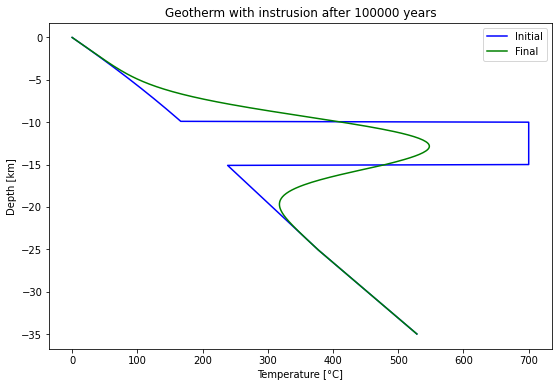

In [14]:
figure(figsize=(9, 6))
plot(Ti, -x/1000, 'b', label='Initial')
plot(Tn, -x/1000, 'g', label='Final')
xlabel('Temperature [°C]')
ylabel('Depth [km]')
legend()
title('Geotherm with instrusion after 100000 years');
show()

## Exercise

Common situation in geodynamics to disturb thermal structure by **deformation**. In this exercise you will start with stable geotherm in layered crust calculated above and you will calculate evolution of geotherm during extension of the crust (crustal thinning) and thickenning of the crust.

The rate of deforatiom will be for thinning $\dot \epsilon = -3 \cdot 10^{-15} s^{-1}$ and for compression $\dot \epsilon = 3 \cdot 10^{-15} s^{-1}$.

Note that change in length is usually described by stretching $S$, which could be calculated from rate of deformation using equation: $S = \exp\left (\dot \epsilon \cdot \Delta t\right )$

The strategy should be to make small time step of deformation (you need to change the thickness of the crust, which affect node distance `dx` and their positions `x`) and for same time step calculate thermal relaxation. This should be repeated until reaching desired times.

Plot in single plot, initial geotherm and geotherms after 1, 2, 3, 4 and 5 Ma of deformation. Use calculation time step 500 years.

### Extension

We will use already calculated steady state solution

In [15]:
Tn = T.copy()
th = 35000                   # thickness of the crust
edot = -3e-15                # rate of deformation
#S = exp(edot*dt)             # deformation for each time step
x = linspace(0, th, n)
dx = x[1] - x[0]

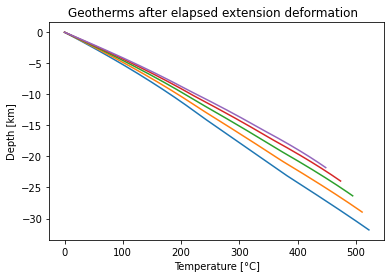

In [16]:

dt = 500 * ysec      # step
S = exp( edot * dt)  # S * 1000 km (kus horniny se o 1 cm zmenší)

for step in range(5):
    for i in range (2000):
        
        th = th * S 
        x = linspace(0, th, n)
        dx = dx * S
        
        l = k[:-1] / dx**2
        r = k[1:] / dx**2
        m = (rho[:-1] + rho[1:]) * (c[:-1] + c[1:]) / (4 * dt)

        dl = hstack((-l, -2*l[-1], 0))
        dh = hstack((1, m+l+r, rho[-1]*c[-1]/dt + 2*l[-1]))
        du = hstack((0, 0, -r))
        A = spdiags([dl, dh, du], [-1,0,1], n, n, 'csr')

        b = hstack((T0, (H[:-1] + H[1:])/2 + m*Tn[1:-1], H[-1]-2*q/dx + Tn[-1]*rho[-1]*c[-1]/dt))

        Tn = spsolve(A, b)
    
    plot(Tn, - linspace (0, th , n) / 1000,label = 'f{step + 1}Ma' )

xlabel('Temperature [°C]')
ylabel('Depth [km]')
title('Geotherms after elapsed extension deformation  ')
show()

In [17]:
print(th)

21801.61525877751


### Compression

We will use already calculated steady state solution

In [18]:
Tn = T.copy()
th = 35000                   # thickness of the crust
edot = 3e-15                # rate of deformation
#S = exp(edot*dt)             # deformation for each time step
x = linspace(0, th, n)
dx = x[1] - x[0]

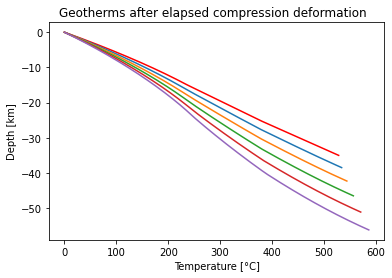

In [19]:

dt = 500 * ysec 
S = exp(edot * dt)

plot(T, -x/1000, "r")

for step in range(5):

    for i in range (2000):

        th = th*S 
        x = linspace(0, th, n)
        dx = dx*S

        l = k[:-1] / dx**2
        r = k[1:] / dx**2
        m = (rho[:-1] + rho[1:]) * (c[:-1] + c[1:]) / (4 * dt)

        dl = hstack((-l, -2 * l[-1], 0))
        dh = hstack((1, m + l + r, rho[-1] * c[-1]/dt + 2 * l[-1]))
        du = hstack((0, 0, -r))
        A = spdiags([dl, dh, du], [-1,0,1], n, n, 'csr')

        b = hstack((T0, (H[:-1] + H[1:]) / 2 + m * Tn[1:-1], H[-1]-2 * q / dx + Tn[-1] * rho[-1] * c[-1]/dt))

        Tn = spsolve(A, b)

    plot(Tn, -linspace (0, th , n) /1000,label = 'f{step + 1}Ma' )

xlabel('Temperature [°C]')
ylabel('Depth [km]')
title('Geotherms after elapsed compression deformation  ');
show()